# Content

[GAN](#GAN)

[DCGAN](#DCGAN)

# GAN

[notebook](https://github.com/nttuan8/GAN_Tutorial/blob/master/G1/GAN-MNIST.ipynb)

In [38]:
# import library
from keras.datasets import mnist
from keras.models import Sequential,Model
from keras.layers import Input,Dense,Dropout,Activation,Flatten,LeakyReLU
from keras.optimizers import adam_v2 #Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm,tqdm_notebook

In [11]:
# take MNIST dataset
(X_train,y_train),(X_test,y_test) = mnist.load_data()
print("X_train: ",X_train.shape)
print("y_train: ",y_train.shape)
print("X_test: ",X_test.shape)
print("y_test: ",y_test.shape)

X_train:  (60000, 28, 28)
y_train:  (60000,)
X_test:  (10000, 28, 28)
y_test:  (10000,)


In [12]:
# preprocess input shape
N = 60000
M = 10000
k = 28*28
X_train = X_train.reshape(N,k)
X_test = X_test.reshape(M,k)
print("X_train: ",X_train.shape)
print("X_test: ",X_test.shape)
# normalize input
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

X_train:  (60000, 784)
X_test:  (10000, 784)


In [15]:
# dimension of noise vector
z_dim = 100

# hypeparameter
lr=0.0002
epochs = 200

In [17]:
# optimizer
adam = adam_v2.Adam(learning_rate=lr,decay=lr/epochs)

**generator**

![img](generator.png)

In [19]:
# Generator
g = Sequential()
g.add(Dense(256,input_dim=z_dim,activation=LeakyReLU(alpha=0.2)))
g.add(Dense(512,activation=LeakyReLU(alpha=0.2)))
g.add(Dense(1024,activation=LeakyReLU(alpha=0.2)))
g.add(Dense(784,activation='sigmoid')) # because we normalized input [0-1] so output of generator must be use sigmoid
#compile generator
g.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])

In [31]:
g.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_3 (Dense)              (None, 784)               803600    
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
_________________________________________________________________


**discriminator**

![img](discriminator.png)

In [20]:
# Discriminator
d = Sequential()
d.add(Dense(1024,input_dim=784,activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(512,activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(256,activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(1,activation='sigmoid'))
# compile discriminator
d.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])

In [32]:
d.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [21]:
d.trainable=False
inputs = Input(shape=(z_dim,))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs,output)
gan.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])

In [34]:
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [43]:
# draw plot function
def plot_loss(losses):
    '''
    Args:
        losses: tuple of generator and discriminator
    '''
    d_loss = [v[0] for v in losses['D']]
    g_loss = [v[0] for v in losses['G']]
    plt.figure(figsize=(10,8))
    plt.plot(d_loss,label='Discriminator loss')
    plt.plot(g_loss,label='Generator loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
# display generated samles
def plot_generated(n_ex=10,dim=(1,10),figsize=(12,2)):
    '''
    Args:
        n_ex: number of sample
        dim:
        figsize:
    '''
    # random noise
    noise=np.random.normal(0,1,size=(n_ex,z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex,28,28)
    plt.figure(figsize=figsize)
    for i in range(n_ex):
        plt.subplot(dim[0],dim[1],i+1)
        plt.imshow(generated_images[i],interpolation='nearest',cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [44]:
# Keep loss values of discriminator and generator
losses = {"D":[],"G":[]}

In [45]:
def train(epochs=1,plt_frq=1,BATCH_SIZE=128):
    '''
    Args:
        epochs: number of epoch
        plt_frq: plot generated image frequency
        BATCH_SIZE: number of sample per batch
    '''
    batch_count = int(X_train.shape[0]/BATCH_SIZE)
    print('Epochs:',epochs)
    print('Batch size:',BATCH_SIZE)
    print('Batches per epoch:',batch_count)
    
    for e in tqdm(range(1,epochs+1)):
        if e==1 or e%plt_frq==0:
            print('-'*15,'Epoch %d'%e,'-'*15)
        for _ in range(batch_count):
            # get random real images from MNIST dataset
            image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE)] #(128,784)
            # generate random noise
            noise = np.random.normal(0,1,size=(BATCH_SIZE,z_dim)) #(128,100)
            # generate images from noise
            generated_images = g.predict(noise)
            X = np.concatenate((image_batch,generated_images))
            # create label, label=1 for image from MNIST, label=0 for image generated by generator
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9
            # train discriminator
            d.trainable = True
            d_loss=d.train_on_batch(X,y)
            # train generator
            noise = np.random.normal(0,1,size=(BATCH_SIZE,z_dim))
            # set label=0 for image from MNIST, label=1 for image generated by generator
            y2=np.ones(BATCH_SIZE)
            # when train generator don't update weight of discriminator
            d.trainable=False
            g_loss = gan.train_on_batch(noise,y2)
        # storage loss function
        losses['D'].append(d_loss)
        losses['G'].append(g_loss)
        # plot generated image
        if e == 1 or e%plt_frq==0:
            plot_generated()
    
    plot_loss(losses)

  0%|          | 0/50 [00:00<?, ?it/s]

Epochs: 50
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------


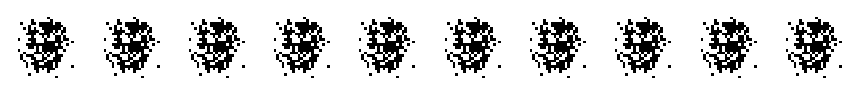

 18%|█▊        | 9/50 [17:14<1:13:42, 107.87s/it]

--------------- Epoch 10 ---------------


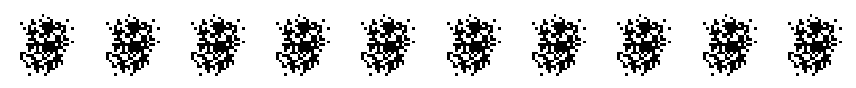

 38%|███▊      | 19/50 [34:59<54:59, 106.42s/it]  

--------------- Epoch 20 ---------------


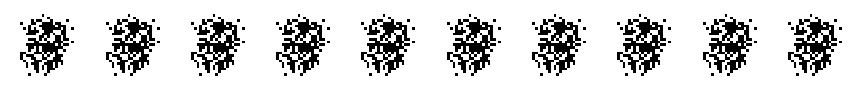

 58%|█████▊    | 29/50 [52:45<37:27, 107.03s/it]

--------------- Epoch 30 ---------------


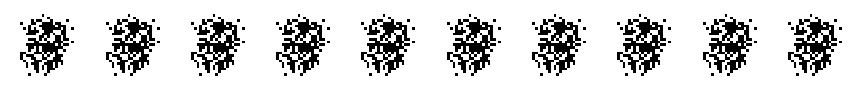

 78%|███████▊  | 39/50 [1:11:31<20:35, 112.35s/it]

--------------- Epoch 40 ---------------


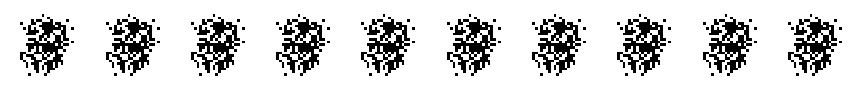

 98%|█████████▊| 49/50 [1:30:15<01:52, 112.10s/it]

--------------- Epoch 50 ---------------


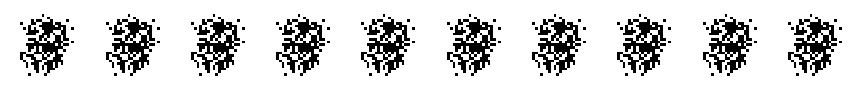

100%|██████████| 50/50 [1:32:07<00:00, 110.54s/it]


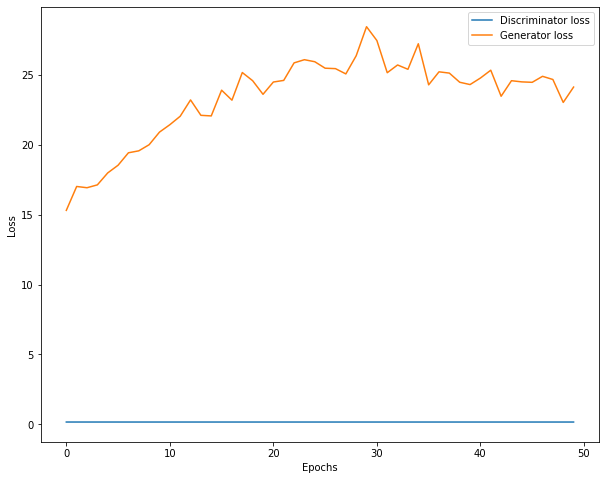

In [46]:
train(epochs=50,plt_frq=10,BATCH_SIZE=128) #train(epochs=200,plt_frq=20,BATCH_SIZE=128) 

# DCGAN

[notebook](https://github.com/nttuan8/GAN_Tutorial/blob/master/G2/DCGAN.ipynb)

# References

[keras optimizer](https://stackoverflow.com/questions/62707558/importerror-cannot-import-name-adam-from-keras-optimizers)

[GAN notebook](https://github.com/nttuan8/GAN_Tutorial/blob/master/G1/GAN-MNIST.ipynb)

[DCGAN notebook](https://github.com/nttuan8/GAN_Tutorial/blob/master/G2/DCGAN.ipynb)

[Bài 0: Giới thiệu series GAN (Generative Adversarial Networks)](https://nttuan8.com/gioi-thieu-series-gan-generative-adversarial-networks/)

[Bài 1: Giới thiệu về GAN](https://nttuan8.com/bai-1-gioi-thieu-ve-gan/)

[Bài 2: Deep Convolutional Generative Adversarial Network (DCGAN)](https://nttuan8.com/bai-2-deep-convolutional-gan-dcgan/)